# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

#### Daniel de Amaral da Silva (BSc on Statistics at University Federal of Ceará - UFC)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This work aims to understand the **economic regions** of the tourist state of **Bahia**, Brazil. 

The city of **Salvador** is often the main target for several tourists from different countries with the aim of having fun, especially during the period related to carnival. 

| ![Picture of Carnaval](https://correio-cdn1.cworks.cloud/fileadmin/_processed_/9/0/csm_carnaval_bloco_63a5062383.jpg) | 
|:--:| 
| *Salvador Carnival* |

In fact, there are many tourist routes and accommodation guides, however, this notebook will make a visualization of the city trying to **partition the city into regions** in order to **identify the economic focus** of each one.

The result of this work can help both people who want to **open their own business** and become micro entrepreneurs or who want to **buy a house/apartment** in Salvador **with a pre-established neighborhood**.

...being clearer

...imagine that a person **wants to live in Salvador**, however, he **doesn't care much about the region of the city, but about the neighborhood**. For example, a couple with children might have a tendency to choose locations with good schools, parks and places to have fun for their children. In contrast, a 19/20 year old could choose locations close to bars and clubs.

We will use our data science powers to generate more **promising regions based on the user's profile**. The advantages of each area will be clearly expressed, so that the best possible final region can be chosen by the interested parties.

## 2. Data

Based on definition of our problem, factors that will influence our decission are only the **number of venues in the neighborhood (any type of venue)**.

We decided to use circular search of locations, centered around each county, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate county areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Geopy API reverse geocoding**
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Bahia/BR center will be obtained using **Geopy API geocoding**.

### Neighborhood Counties Candidates

Let's create latitude & longitude coordinates for centroids of our candidate counties neighborhoods, areas and their respective radius. 

Fortunately we can obtain all the names of the counties of the state of bahia and their respective areas $(km^2)$ by accessing the data from IBGE (Brazilian Institute of Geography and Statistics).

this way, for each county we will have the search radius to find the neighborhood

In [1]:
import pandas as pd

neighborhoods = pd.read_csv('https://raw.githubusercontent.com/damarals/Coursera_Capstone/master/mapa.csv')
neighborhoods.columns = ['Neighborhood', 'Area']

neighborhoods.head()

,Neighborhood,Area
0,Alcobaça,1477.929
1,Almadina,245.236
2,Anagé,1899.683
3,Arataca,435.962
4,Aurelino Leal,445.394


...a naive approach to determining the radius of each county is to imagine that each is a perfect circumference centered on its coordinates, using the following formula

$$radius = \sqrt{\frac{area}{\pi}}$$

In [2]:
import numpy as np
import math

neighborhoods['Radius'] = np.sqrt(neighborhoods.Area/math.pi).round(3)

lets get the coordinates latitude and longitude for each county using geopy

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>bahia_explorer</em>, as shown below.

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter # delay between geocoding calls
from geopy.exc import GeocoderTimedOut # error messages

locator = Nominatim(user_agent= 'bahia_explorer')

geocode = RateLimiter(locator.geocode, min_delay_seconds = 0.5)

try:
    neighborhoods['Location'] = (neighborhoods.Neighborhood + ', Bahia - Brasil').apply(lambda neigh: geocode(neigh, timeout = 10000))
    neighborhoods['Point'] = neighborhoods['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
    neighborhoods[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(neighborhoods['Point'].tolist(), index = neighborhoods.index)
    neighborhoods.drop(['Location', 'Point', 'Altitude', 'Area'], axis = 1, inplace = True)
except GeocoderTimedOut as e:
    print('Error: geocode failed with message {}'.format(e.message))

In [4]:
neighborhoods.head()

,Neighborhood,Radius,Latitude,Longitude
0,Alcobaça,21.690,-17.521587,-39.196547
1,Almadina,8.835,-14.704660,-39.638199
2,Anagé,24.590,-14.613467,-41.137631
3,Arataca,11.780,-15.261742,-39.412294
4,Aurelino Leal,11.907,-14.316714,-39.325611


And make sure that the dataset has all 417 counties.

In [5]:
print('The dataframe has {} counties.'.format(neighborhoods.shape[0]))

The dataframe has 417 counties.


Let's find the latitude & longitude of Bahia city center using geopy API.

In [6]:
try:
    bahia_center = geocode('Bahia, Brasil', timeout = 10000)
    print('The geograpical coordinate of Bahia state is {}'.format(bahia_center[1]))
except GeocoderTimedOut as e:
    print('Error: geocode failed with message {}'.format(e.message))

The geograpical coordinate of Bahia state is (-12.285251, -41.9294776)


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [7]:
import folium
import unidecode # remove accentuation, avoid problems

map_bahia = folium.Map(location = bahia_center[1], zoom_start = 6)
for lat, lon, county in zip(neighborhoods.Latitude, 
                    neighborhoods.Longitude,
                    neighborhoods.Neighborhood):
    label = folium.Popup(unidecode.unidecode(county), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_bahia) 

map_bahia

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on venues in each neighborhood.

We're interested in all venues... coffe shops, gyms, pizza places, bakeries, schools...

In [8]:
# The code was removed by Watson Studio for sharing.

Foursquare API version: 20180605


Let's create a function to explore all the neighborhoods in Bahia

In [9]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT = 100):
    
    venues_list=[]
    
    radius = [i.replace(".", "") for i in radius.astype('str')]
    i = 1
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
        
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print('Falha')
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

applying funcion in each neighborhood


In [10]:
bahia_venues = getNearbyVenues(names = neighborhoods.Neighborhood, latitudes = neighborhoods.Latitude,
                              longitudes = neighborhoods.Longitude, radius = neighborhoods.Radius)

Falha


Let's check the size of the resulting dataframe

In [11]:
print(bahia_venues.shape)
bahia_venues.head()

(5482, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alcobaça,-17.521587,-39.196547,Farol de Alcobaça,-17.519936,-39.193818,Lighthouse
1,Alcobaça,-17.521587,-39.196547,Cabana Do Compadre,-17.517453,-39.192121,Seafood Restaurant
2,Alcobaça,-17.521587,-39.196547,Praia de Alcobaça,-17.536714,-39.193224,Beach
3,Alcobaça,-17.521587,-39.196547,Cabana do Cal,-17.533172,-39.191577,Snack Place
4,Alcobaça,-17.521587,-39.196547,Balneário de Alcobaça,-17.534591,-39.191883,Beach


Let's check how many venues were returned for each neighborhood (county)

In [12]:
import matplotlib.pyplot as plt

bahia_venues_10 = bahia_venues.groupby('Neighborhood').count().query('Venue >= 10')
ax = bahia_venues_10['Venue Category'].plot(kind = 'barh', figsize=(20,40))

ax.set_xlabel("#Venue")
ax.set_ylabel("County")
plt.show()

<Figure size 2000x4000 with 1 Axes>

In [13]:
print('There are {} counties with 10+ venues.'.format(bahia_venues_10.shape[0]))

There are 138 counties with 10+ venues.


Note that of the 417 counties, we only had 368 records... a reduction of about $11.75\%$

In [14]:
map_bahia = folium.Map(location = bahia_center[1], zoom_start = 6)

dec = np.vectorize(unidecode.unidecode)
ind = dec(bahia_venues_10.index)

for lat, lon, county in zip(neighborhoods.Latitude, 
                    neighborhoods.Longitude,
                    neighborhoods.Neighborhood):
    label = folium.Popup(unidecode.unidecode(county), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 7 if county in ind else 3,
        popup = label,
        color = 'blue' if county in ind else 'grey',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_bahia) 

map_bahia

In [15]:
print('There are {} uniques categories.'.format(len(bahia_venues['Venue Category'].unique())))

There are 298 uniques categories.


In [16]:
bahia_venues = bahia_venues[bahia_venues.Neighborhood.isin(bahia_venues_10.index.values)]

# one hot encoding
bahia_onehot = pd.get_dummies(bahia_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bahia_onehot['Neighborhood'] = bahia_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bahia_onehot.columns[-1]] + list(bahia_onehot.columns[:-1])
bahia_onehot = bahia_onehot[fixed_columns]

bahia_onehot.head()

,Women's Store,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,American Restaurant,Aquarium,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Shop,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
bahia_grouped = bahia_onehot.groupby('Neighborhood').mean().reset_index()
bahia_grouped

,Neighborhood,Women's Store,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Shop,Wings Joint
0,Abaré,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0625,0.00,0.000000,0.000000
1,Alagoinhas,0.000000,0.000000,0.000000,0.016393,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
2,Alcobaça,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
3,Amargosa,0.029412,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
4,Amélia Rodrigues,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
5,Antônio Gonçalves,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
6,Araci,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
7,Aramari,0.000000,0.000000,0.000000,0.027027,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
8,Aratuípe,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000
9,Aurelino Leal,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.00,0.000000,0.000000


In [18]:
num_top_venues = 5

for hood in bahia_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bahia_grouped[bahia_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abaré----
         venue  freq
0  Pizza Place  0.12
1        Plaza  0.12
2   Lighthouse  0.06
3     Creperie  0.06
4    Rest Area  0.06


----Alagoinhas----
                  venue  freq
0              Pharmacy  0.07
1            Restaurant  0.07
2           Pizza Place  0.05
3  Fast Food Restaurant  0.05
4                 Plaza  0.05


----Alcobaça----
                venue  freq
0               Hotel  0.11
1         Snack Place  0.11
2               Beach  0.11
3  Seafood Restaurant  0.11
4          Restaurant  0.06


----Amargosa----
           venue  freq
0          Plaza  0.09
1         Bakery  0.09
2          Hotel  0.06
3  Grocery Store  0.06
4     Shoe Store  0.06


----Amélia Rodrigues----
                  venue  freq
0            Food Truck  0.17
1                Market  0.11
2             Juice Bar  0.11
3  Brazilian Restaurant  0.11
4        Soccer Stadium  0.06


----Antônio Gonçalves----
             venue  freq
0    Deli / Bodega  0.10
1      Pizza Place  0.10
2    

Let's put that into a *pandas* dataframe

but first we are going to write a function to sort the places in descending order.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = bahia_grouped['Neighborhood']

for ind in np.arange(bahia_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bahia_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abaré,Pizza Place,Plaza,Restaurant,Beach,Food Truck,Lighthouse,Rest Area,Creperie,Department Store,Diner
1,Alagoinhas,Pharmacy,Restaurant,Fast Food Restaurant,Plaza,Snack Place,Pizza Place,Burger Joint,Hotel,Bed & Breakfast,Café
2,Alcobaça,Snack Place,Seafood Restaurant,Beach,Hotel,Gastropub,Soccer Stadium,Beer Store,Motorcycle Shop,Brazilian Restaurant,Lighthouse
3,Amargosa,Plaza,Bakery,Grocery Store,Hotel,Shoe Store,Pizza Place,Women's Store,Beer Bar,Big Box Store,Brazilian Restaurant
4,Amélia Rodrigues,Food Truck,Juice Bar,Market,Brazilian Restaurant,Soccer Stadium,Gym / Fitness Center,Breakfast Spot,Resort,Plaza,Bed & Breakfast


In [21]:
neighborhoods_venues_sorted.shape

(138, 11)

## Methodology <a name="methodology"></a>

In this project, we will direct our analytical efforts to detect areas in the state of Bahia with a certain minimum of locations (min = 10). Although we "lose" about 80% of the counties, we have more transparency in the analysis.

In the first step, we collect the necessary data: **location and type (category) of each venue centered in the county**.

In the second and final step, we’ll create **groups of locations that meet some basic caracteristics**. We will present the map of all these locations, but we will also create clusters (using the **k-modes** grouping) of these locations to identify zones / neighborhoods / general addresses that have features in common.

## Analysis <a name="analysis"></a>

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

But first we need to get **Silhouette Score** for choose best _k_.

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics

bahia_grouped_clustering = bahia_grouped.drop('Neighborhood', 1)

sc = []
for k in range(2, 15):
    kmeansModel = KMeans(n_clusters = k, random_state = 1).fit(bahia_grouped_clustering)
    labels = kmeansModel.labels_
    sc.append(metrics.silhouette_score(bahia_grouped_clustering, labels))

# standardizing asw for visualizing better
sc = (sc - np.mean(sc)) / np.std(sc)

Let's view the scores

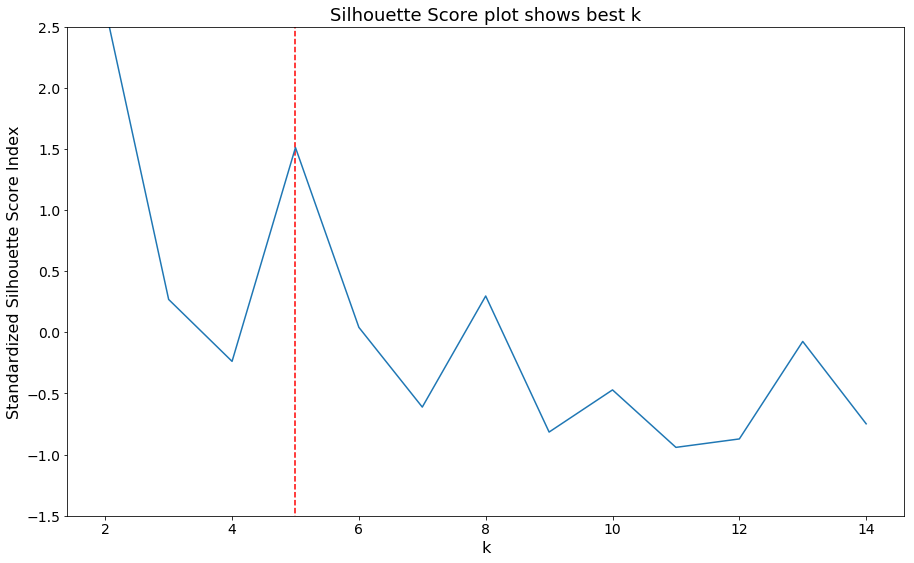

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,9))
plt.plot(range(2,15), sc)
plt.vlines(x = 5, ymin = -2, ymax = 3, linestyles='dashed', colors = 'red')
plt.xlabel('k', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([-1.5, 2.5])
plt.title('Silhouette Score plot shows best k', fontsize = 18)
plt.ylabel('Standardized Silhouette Score Index', fontsize = 16)
plt.show()

A great tradeoff is found with k = 5, in which we have multiples clusters and a high distinction between groups ( max _silhouette score_ ).

Starting clustering with k-Modes

In [24]:
# run k-means clustering
kmodesModel = KMeans(n_clusters = 5, random_state = 1).fit(bahia_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmodesModel.labels_

array([2, 1, 3, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 0, 3, 1, 4, 1, 1, 2, 1, 3,
       1, 1, 3, 1, 4, 1, 3, 1, 1, 2, 0, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 3, 1, 4, 4, 1, 1, 1, 3, 0, 4, 1,
       1, 3, 1, 4, 4, 1, 0, 1, 4, 1, 3, 1, 1, 1, 1, 1, 0, 2, 1, 0, 3, 1,
       1, 1, 2, 1, 1, 0, 3, 0, 2, 1, 4, 2, 3, 3, 2, 1, 2, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1,
       0, 1, 3, 3, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmodesModel.labels_)

bahia_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bahia_merged = bahia_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bahia_merged.dropna(inplace = True)

bahia_merged.head() # check the last columns!

,Neighborhood,Radius,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alcobaça,21.690,-17.521587,-39.196547,3.0,Snack Place,Seafood Restaurant,Beach,Hotel,Gastropub,Soccer Stadium,Beer Store,Motorcycle Shop,Brazilian Restaurant,Lighthouse
4,Aurelino Leal,11.907,-14.316714,-39.325611,4.0,Ice Cream Shop,Public Art,Bus Station,Bakery,Department Store,Food Truck,Italian Restaurant,Brazilian Restaurant,Burger Joint,Gym / Fitness Center
7,Belmonte,24.846,-15.863084,-38.879284,3.0,Pizza Place,Beach,Brazilian Restaurant,Plaza,Ice Cream Shop,Food,Restaurant,German Restaurant,Baiano Restaurant,Bakery
13,Camacan,13.644,-15.416663,-39.493009,1.0,Plaza,Cycle Studio,Snack Place,Brazilian Restaurant,Shopping Mall,Diner,Market,Boutique,Ice Cream Shop,Wings Joint
14,Canavieiras,20.609,-15.679013,-38.944962,3.0,Pizza Place,Beach,Plaza,Ice Cream Shop,Food,Restaurant,Brazilian Restaurant,German Restaurant,Baiano Restaurant,Bakery


Now we are going to visualize the **counties** and their respective **clusters**

In [26]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location= bahia_center[1], zoom_start=6)

# set color scheme for the clusters
x = np.arange(0, 7)
ys = [i + x + (i*x)**7 for i in x]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bahia_merged['Latitude'], bahia_merged['Longitude'], 
                                  bahia_merged['Neighborhood'], bahia_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We will obtain a bar graph based on the top venues (3+ venues) of each cluster

In [27]:
bahia_merged['Cluster Labels'] = bahia_merged['Cluster Labels'].astype('int').astype('str')

In [28]:
ba_plot = bahia_merged.groupby(['Cluster Labels'])['1st Most Common Venue'].value_counts().unstack()

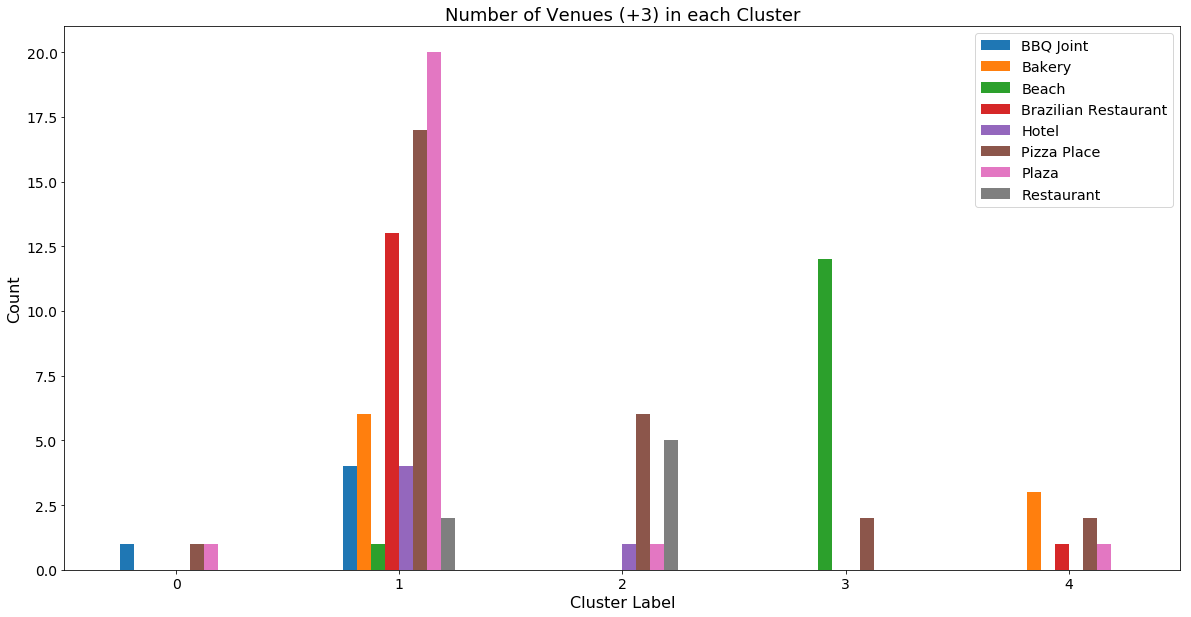

In [29]:
ba_plot.loc[:, (ba_plot > 3).any(axis = 0)].plot(kind='bar', figsize=(20,10), fontsize = 14)
plt.xticks(rotation=0)
plt.ylabel('Count', fontsize = 16)
plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large") # using a named size
plt.xlabel('Cluster Label', fontsize = 16)
plt.title('Number of Venues (+3) in each Cluster', fontsize = 18)
plt.show()

Let's add the column of the clusters labels and the "junction" of the top 3 venues

In [34]:
Join = []
for _1st, _2st, _3st in zip(bahia_merged['1st Most Common Venue'],
                           bahia_merged['2nd Most Common Venue'],
                           bahia_merged['3rd Most Common Venue']):
    Join.append('{}, {} and {}'.format(_1st, _2st, _3st))
bahia_merged['Join'] = Join

In [35]:
dictionary = {'4': 'Residencial Social Venues',
              '3': 'Coastal Area',
              '2': 'Center Area',
              '1': 'Multiple Social Venues (High Density)',
              '0': 'Multiple Social Venues (Low Density)'}

In [36]:
Labels = []
for cl_label in bahia_merged['Cluster Labels'].values:
    Labels.append(dictionary[cl_label])
bahia_merged['Labels'] = Labels

In [37]:
bahia_merged.drop(['Cluster Labels'], axis = 1, inplace = True)
bahia_merged.head()

,Neighborhood,Radius,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Join,Labels
0,Alcobaça,21.690,-17.521587,-39.196547,Snack Place,Seafood Restaurant,Beach,Hotel,Gastropub,Soccer Stadium,Beer Store,Motorcycle Shop,Brazilian Restaurant,Lighthouse,"Snack Place, Seafood Restaurant and Beach",Coastal Area
4,Aurelino Leal,11.907,-14.316714,-39.325611,Ice Cream Shop,Public Art,Bus Station,Bakery,Department Store,Food Truck,Italian Restaurant,Brazilian Restaurant,Burger Joint,Gym / Fitness Center,"Ice Cream Shop, Public Art and Bus Station",Residencial Social Venues
7,Belmonte,24.846,-15.863084,-38.879284,Pizza Place,Beach,Brazilian Restaurant,Plaza,Ice Cream Shop,Food,Restaurant,German Restaurant,Baiano Restaurant,Bakery,"Pizza Place, Beach and Brazilian Restaurant",Coastal Area
13,Camacan,13.644,-15.416663,-39.493009,Plaza,Cycle Studio,Snack Place,Brazilian Restaurant,Shopping Mall,Diner,Market,Boutique,Ice Cream Shop,Wings Joint,"Plaza, Cycle Studio and Snack Place",Multiple Social Venues (High Density)
14,Canavieiras,20.609,-15.679013,-38.944962,Pizza Place,Beach,Plaza,Ice Cream Shop,Food,Restaurant,Brazilian Restaurant,German Restaurant,Baiano Restaurant,Bakery,"Pizza Place, Beach and Plaza",Coastal Area


## Results and Discussion <a name="results"></a>

Our analysis shows that while there are a large number of restaurants in Berlin, there are low-density pockets of restaurants very close to the city center. The highest concentration of restaurants was detected in the outskirts of Salvador, which offers a perfect combination of popularity among tourists, proximity to the city center, and of course beautiful beaches and historic centers.

Counties with more than 10 records have been grouped to create zones of economic interest. The addresses of the centers in these zones were also generated using reverse geocoding to be used as markers/starting points.

Regarding applied clustering, the k-means method is not the most suitable for working with categorical data types, but the k-modes algorithm, an extension of k-means. We ended up using the k-means method because it is well implemented and we have great support from the scikit-learn library

The result of all this is 5 zones/groups of counties that contain their characteristics, such as the coastal zone and central zones where the economy is well developed not only by the tourist side. This does not imply that these zones are representative of those places! The purpose of this analysis was to provide only information about areas of the state of Bahia based on data from foursquare API records, note that there may be locations that are not tracked by the API and that have not entered our analyzes - there may be a good reason for a small number of restaurants/hotels in any of these areas, regardless of the lack of competition in the area. The regions found should, therefore, be considered only as a starting point for more detailed analysis and generation of insights.

## Conclusion <a name="conclusion"></a>

This project aimed to identify and segment areas of the state of Bahia based on the characteristics of local economic activities, to help interested parties to restrict the search for the ideal location based on a pre-established neighbor. When calculating the density distribution of venues from the foursquare API data, we identify the top venues in each county/neighborhood. The grouping of these sites was carried out to create the main zones of interest (containing the largest number of potential sites) and the addresses of these zone centers were created to be used as starting points for the final exploration by the interested parties.

The decision to take a neighborhood is made by the interested parties and our work tries to help to identify potential neighborhoods that can meet the profile of the interested parties.